In [97]:
import numpy as np
from sentle import sentle
from dotenv import load_dotenv
import geopandas as gpd
from pathlib import Path
import os
import torch
import xarray as xr
import matplotlib.pyplot as plt
import fiona
import logging
import time
import rioxarray
from shapely.geometry import mapping 

In [144]:
# Set up .env path 
# env_path = Path('/net/projects/EO4BK/WP1/P1-EO4BK/scripts/EO4BK-WP1-P1/.env')
# load_dotenv(dotenv_path=env_path)

# poly_path = f"{os.getenv('LUCS_CPN_POLY_DE12C')}/LUCAS_CPNS_DE12C_sample.gpkg"
poly_path = f"{os.getenv('LUCS_CPN_POLY_DE12C')}/LUCAS_CPNS_DE12C_sample.gpkg"

lcs_cpns_poly = gpd.read_file(poly_path)

# slcs_cpns_polyubset = lcs_cpns_poly[:4]


# Configure logging
logging.basicConfig(
    level=logging.INFO,  # Set the desired logging level
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),  # Logs to the console
        logging.FileHandler('sentinel_processing_3.log')  # Logs to a file
    ]
)
logger = logging.getLogger()


def load_sentle(poly_path, idx, res):
    """
    Load Sentinel data using the Sentle library for a given grid.
    """
    try:
        lcs_cpns_poly = gpd.read_file(poly_path)
        bounds = idx + 1
        bounds = lcs_cpns_poly[idx:bounds].geometry.iloc[0].bounds
        bound_left = int(bounds[0])
        bound_bottom = int(bounds[1])
        bound_right = int(bounds[2])
        bound_top = int(bounds[3])
        equi7_crs = lcs_cpns_poly.crs
        logger.info(f"Resolution: {res}")

        da = sentle.process(
            target_crs=equi7_crs,
            bound_left=bound_left,
            bound_bottom=bound_bottom,
            bound_right=bound_right,
            bound_top=bound_top,
            datetime="2022-07-01/2022-08-31",
            target_resolution=res,
            S2_mask_snow=True,
            S2_cloud_classification=True,
            S2_cloud_classification_device="cpu",
            S1_assets=["vv", "vh"],
            S2_apply_snow_mask=True,
            S2_apply_cloud_mask=True,
            time_composite_freq="7d",
            # NOTE clemens: this can be set to 40
            num_workers=7,
        )
        # to restore the original function delete last two rows and return da 
        da = da.rio.write_crs(lcs_cpns_poly.crs)   # write crs from polygon 
        da_cl = da.rio.clip(lcs_cpns_poly.geometry.apply(mapping), lcs_cpns_poly.crs)  # and clip raster with polygon 
        return da_cl
    except Exception as e:
        logger.error(f"Error in load_sentle function for index {idx}: {e}")
        raise

load_sentle(poly_path=poly_path, idx = 2, res = 10)

def process_and_save(poly_path, idx, point_id, res):
    """
    Process and save Sentinel data for a given index.
    """
    try:
        logger.info(f"> Load the Minicube {idx} ...")
        da = load_sentle(poly_path=poly_path, idx=idx, res=res)
        logger.info(f"> Save the Minicube {idx} ...")
        output_zarr_path = f"{os.getenv('MINICUBES_PATHv2')}/LUCAS_CPNS_{point_id}_{res}.zarr"
        sentle.save_as_zarr(da, path=output_zarr_path)
        logger.info(f"> Successfully saved the Minicube {idx} at {output_zarr_path} ...")
    except Exception as e:
        logger.error(f"An error occurred for index {idx}: {e}")


def main():
    start_time = time.time()  # Capture the start time

    try:
        # Load the Environment variables
        env_path = Path('/net/projects/EO4BK/WP1/P1-EO4BK/scripts/EO4BK-WP1-P1/.env')
        load_dotenv(dotenv_path=env_path)

        # NOTE clemens
        # if below does not work, try to set the CUDA_VISIBLE_DEVICES through the terminal before running the script
        # with `export CUDA_VISIBLE_DEVICES=2`

        # Set CUDA environment
        os.environ["CUDA_VISIBLE_DEVICES"] = "2"
        logger.info(f"> Available CUDA devices: {torch.cuda.device_count()}")

        # Set resolution of the grid that  i want to load
        res = 10
        nuts3 = 'DE12C'
        # Path to grid_file
        poly_path = f"{os.getenv('LUCS_CPN_POLY_DE12C')}/LUCAS_CPNS_DE12C_sample.gpkg"
        
        #intersected_gdf_equi7 = gpd.read_file(grid_path)
        start_idx = 0
        end_idx = 1 #len(intersected_gdf_equi7) - 1  # This is up to 3997  so i just tried with a shorter range for testing


        # NOTE clemens
        # do a simple for-loop here, the sentle process function is already parallelized
        for idx in range(start_idx, end_idx + 1):
            process_and_save(poly_path, idx, lcs_cpns_poly.point_id[idx], res)

        # # Use ThreadPoolExecutor with a limit of 5 concurrent workers
        # with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        #     futures = [executor.submit(process_and_save, grid_path, idx, res) for idx in range(start_idx, end_idx + 1)]
        #     # Wait for all futures to complete
        #     for future in concurrent.futures.as_completed(futures):
        #         pass  # You can handle results if needed


    except Exception as e:
        logger.error(f"An error occurred in the main execution: {e}")

    end_time = time.time()  # Capture the end time
    elapsed_time = end_time - start_time
    logger.info(f"Total execution time: {elapsed_time:.2f} seconds")

if __name__ == "__main__":
    main()



2024-09-18 15:06:38,303 - INFO - Resolution: 10


2024-09-18 15:06:38,863 - distributed.protocol.core - INFO - Failed to serialize (can not serialize 'GeoDataFrame' object); falling back to pickle. Be aware that this may degrade performance.
/net/home/dschierbaum/.conda/envs/wp1v2/lib/python3.12/site-packages/sentle/sentle.py:881: UserWarning: Specified top/bottom bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(
/net/home/dschierbaum/.conda/envs/wp1v2/lib/python3.12/site-packages/sentle/sentle.py:888: UserWarning: Specified left/right bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(
2024-09-18 15:06:40,141 - INFO - > Available CUDA devices: 1
2024-09-18 15:06:40,142 - INFO - > Load the Minicube 0 ...
2024-09-18 15:06:40,179 - INFO - Resolution: 10
2024-09-18 15:06:40,787 - distributed.protocol.core - INFO - Failed to serialize (can no

# Plot Polygon and Raster 

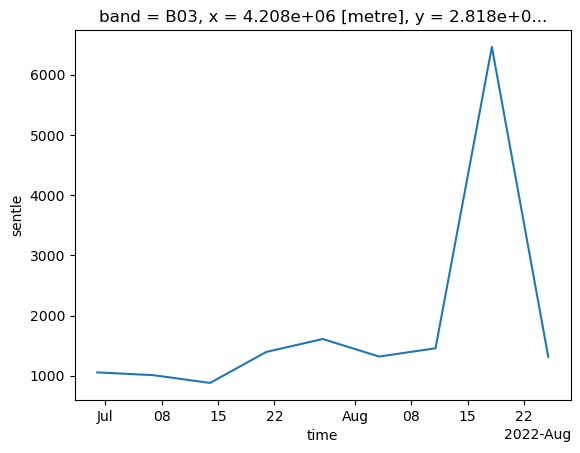

In [157]:
minicube_42082818.sentle.sel(band = ['B03']).isel(x= 1 , y= 1).plot()

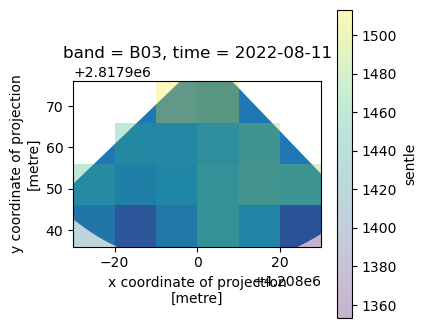

In [152]:
minicube_42082818 = xr.open_zarr('/net/projects/EO4BK/WP1/P1-EO4BK/data/Sent2Timestep/LUCAS_CPNS_42082818_10.zarr')
poly_42082818  = lcs_cpns_poly[lcs_cpns_poly['point_id']== 42082818]

fig, ax = plt.subplots(figsize = (4,4))

poly_42082818.plot(ax = ax )
minicube_42082818.sentle.sel(band=['B03']).isel(time = 3).plot(alpha = 0.3)

In [ ]:
# in case there is the need to extract the maximum sized square inside the polygon https://algo.monster/liteproblems/85

In [ ]:
# Writing the datacube 

from geocube.api.core import make_geocube
out_grid = make_geocube(poly_42302820, like = test_array_42302820)